In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_actions = pd.read_parquet('../data/raw/train_actions.pq', engine='pyarrow')
stokman_catalog = pd.read_parquet('../data/raw/stokman_catalog_preprocessed.pq', engine = 'pyarrow')
catalog_vector_map = pd.read_parquet('../data/raw/catalog_vector_mapping.pq')
npz = np.load('../data/raw/vectors.npz')

In [8]:
vectors_df = pd.DataFrame(npz['arr_0'])
vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.083243,0.048154,0.021908,0.046554,0.016020,0.017390,0.068655,0.003578,-0.101042,0.001614,...,-0.054967,-0.026560,-0.024370,-0.017317,-0.063028,-0.019044,-0.052011,-0.101291,0.106851,0.016866
1,-0.029639,0.046028,0.021950,0.022532,-0.110691,-0.053836,0.057446,0.030473,-0.027846,-0.031509,...,-0.030721,-0.021226,0.032937,0.052792,0.017208,0.001812,0.013390,0.001876,0.078863,-0.012866
2,-0.021771,0.093553,-0.050793,-0.000166,0.049989,0.075398,0.039691,-0.007549,-0.023111,-0.061027,...,-0.120556,-0.007603,-0.057520,0.018594,-0.047227,-0.030704,-0.002737,-0.181192,-0.027767,0.057662
3,-0.010277,0.072384,0.014594,0.097766,0.000443,-0.059049,0.039525,0.008496,-0.037287,-0.064468,...,-0.126487,0.015420,-0.012856,-0.025929,-0.033612,0.076626,0.127795,-0.148789,0.051517,0.061379
4,-0.012528,-0.019212,0.047336,0.084923,0.005401,0.029530,-0.033076,-0.002323,-0.042567,-0.027429,...,-0.091939,0.005534,0.009784,-0.035835,0.001122,0.054081,-0.015952,-0.100471,0.075144,0.016150


In [10]:
train_actions.head()

,user_id,loc_user_id,action,date,products,pageId
0,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:04,[],2571824865
1,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:08,[],3834364438
2,f9c498ec-5d3b-11ef-86e0-002590c0647c,120c9064-1131-4dc3-8048-44184531b42e,7,2024-09-07 00:00:08,[],2448628415
3,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,7,2024-09-07 00:00:11,[],3875013967
4,badbd396-6cab-11ef-86e0-002590c0647c,73423d85-d47c-4332-8155-5200615302b5,7,2024-09-07 00:00:11,[],3025531174


In [220]:
dates = pd.to_datetime(train_actions.date)
print(f'min_date = {min(dates)}, max_date = {max(dates)}')

min_date = 2024-09-07 00:00:04, max_date = 2024-09-28 23:59:59


Минимальный препроцессинг:

In [16]:
train_actions_processed = train_actions.copy()
train_actions_processed.date = pd.to_datetime(train_actions_processed.date)
train_actions_processed = train_actions_processed.explode('products')
train_actions_processed.products = train_actions_processed.products.fillna(0)
train_actions_processed.products = train_actions_processed.products.astype(int)
train_actions_processed.rename({'products': 'productId'}, axis=1, inplace=True)

In [17]:
print(train_actions_processed.head())
print(train_actions_processed.info())

                                user_id                           loc_user_id  \
0  6fd49b56-8cc6-11ed-86e0-002590c0647c  c6e357dc-121d-449d-a744-e9a0b56c2380   
1  6fd49b56-8cc6-11ed-86e0-002590c0647c  c6e357dc-121d-449d-a744-e9a0b56c2380   
2  f9c498ec-5d3b-11ef-86e0-002590c0647c  120c9064-1131-4dc3-8048-44184531b42e   
3  59386b5c-e64f-11ec-8086-002590c82437  f0745572-893f-4e50-bc52-5af47badff5a   
4  badbd396-6cab-11ef-86e0-002590c0647c  73423d85-d47c-4332-8155-5200615302b5   

   action                date  productId      pageId  
0       7 2024-09-07 00:00:04          0  2571824865  
1       7 2024-09-07 00:00:08          0  3834364438  
2       7 2024-09-07 00:00:08          0  2448628415  
3       7 2024-09-07 00:00:11          0  3875013967  
4       7 2024-09-07 00:00:11          0  3025531174  
<class 'pandas.core.frame.DataFrame'>
Index: 6859002 entries, 0 to 6580935
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_

In [195]:
productId_pageId_mapping = train_actions[['products', 'pageId']][
    (train_actions['pageId'].notna()) & 
    (train_actions['products'].apply(len) == 1) & 
    train_actions['action'].isin([0, 7])]
productId_pageId_mapping = productId_pageId_mapping.explode('products')
productId_pageId_mapping.rename(columns={'products':'productId'}, inplace=True)

In [187]:
action_counts = pd.DataFrame()
for action in range(10):
    action_col = f'action_{action}'
    
    action_count = train_actions_exploded[train_actions_exploded['action'] == action].groupby('loc_user_id').size()
    
    action_count_df = action_count.reset_index(name=action_col)
    
    if action_counts.empty:
        action_counts = action_count_df
    else:
        action_counts = action_counts.merge(action_count_df, on='loc_user_id', how='outer')
    
    action_counts.fillna(0, inplace=True)

action_coutns = action_counts.dropna()

- 0 - view (просмотр товара)
- 1 - like (лайк товара)
- 2 - addB (добавление товара в корзину)
- 3 - delB (удаление товара из корзины)
- 4 - clearB (удаление всех товаров из корзины)
- 5 - order (оформление заказа)
- 6 - listB (посещение страницы корзины и вывод списка товаров в корзине)
- 7 - visit (посещение страницы с товаром)
- 8 - visitCategory (посещение страницы с группой товаров)
- 9 - search (поиск товара)

<Axes: >

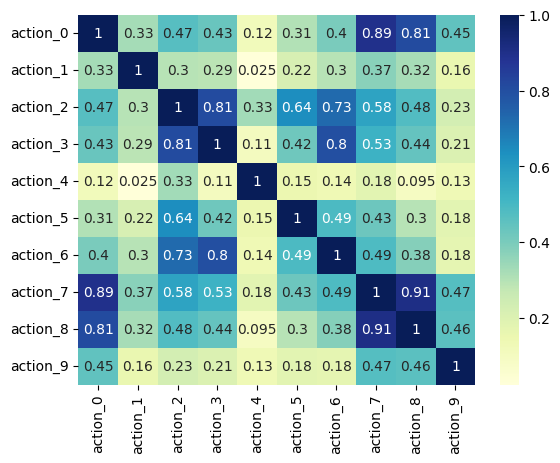

In [192]:
a = action_counts.drop('loc_user_id', axis=1)
sns.heatmap(data=a.corr(), annot=True, cmap='YlGnBu')